In [2]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
from pathlib import Path
from sklearn import metrics

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: 

In [3]:
adata = sc.read_h5ad('../data/BaristaSeq/Slice_2_removed.h5ad')
print("adata 形状:", adata.shape)

adata 形状: (2042, 79)


In [4]:
x_pixel = adata.obsm['spatial'][:,0]
y_pixel = adata.obsm['spatial'][:,1]
print(len(x_pixel))
adj = spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
print("adata 形状:", adata.shape)

2042
Calculateing adj matrix using xy only...
adata 形状: (2042, 79)


In [5]:
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [6]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 1762.1574591247916]
Run 2: l [0.01, 500.005], p [0.0, 1244.9478759765625]
Run 3: l [0.01, 250.0075], p [0.0, 576.8692016601562]
Run 4: l [0.01, 125.00874999999999], p [0.0, 189.56761169433594]
Run 5: l [0.01, 62.509375], p [0.0, 53.02605438232422]
Run 6: l [0.01, 31.2596875], p [0.0, 13.707534790039062]
Run 7: l [0.01, 15.63484375], p [0.0, 3.231299877166748]
Run 8: l [0.01, 7.822421875], p [0.0, 0.5820058584213257]
Run 9: l [3.9162109375, 7.822421875], p [0.04471421241760254, 0.5820058584213257]
Run 10: l [5.86931640625, 7.822421875], p [0.2344118356704712, 0.5820058584213257]
Run 11: l [6.845869140625, 7.822421875], p [0.3898674249649048, 0.5820058584213257]
Run 12: l [7.3341455078125, 7.822421875], p [0.4815354347229004, 0.5820058584213257]
Run 13: l [7.3341455078125, 7.57828369140625], p [0.4815354347229004, 0.530691385269165]
recommended l =  7.456214599609375


In [7]:
n_clusters = len(adata.obs['Region'].unique())
print(n_clusters)
#Set seed
r_seed=t_seed=n_seed=100
#Seaech for suitable resolution
print("adata 形状:", adata.shape)
print("adj 形状:", adj.shape)
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

6
adata 形状: (2042, 78)
adj 形状: (2042, 2042)
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  5
Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Res =  0.7999999999999999 Num of clusters =  6
recommended res =  0.7999999999999999


In [10]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obsm['feature'] = prob
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')

Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
Epoch  80
Epoch  90
Epoch  100
Epoch  110
Epoch  120
Epoch  130
Epoch  140
Epoch  150
Epoch  160
Epoch  170
Epoch  180
Epoch  190


In [11]:
adata

AnnData object with n_obs × n_vars = 2042 × 78
    obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'Region', 'pred'
    uns: 'layer_colors', 'log1p'
    obsm: 'spatial', 'feature'

In [12]:
output_dir1 = ('./feature')
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)
output_path = os.path.join(output_dir1, "ba2-SpaGCN.h5ad")
adata.write_h5ad(output_path)

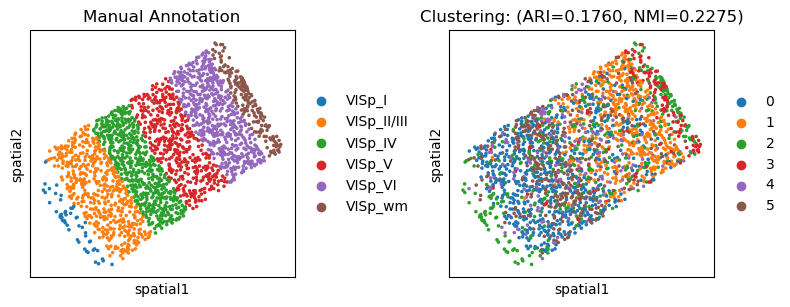

In [10]:
sub_adata = adata[~pd.isnull(adata.obs['Region'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['Region'], sub_adata.obs['pred'])
NMI = metrics.normalized_mutual_info_score(sub_adata.obs['Region'], sub_adata.obs['pred'])
fig, axes = plt.subplots(1,2,figsize=(4*2, 4))
sc.pl.spatial(adata, color='Region', ax=axes[0], show=False, spot_size=20)
sc.pl.spatial(adata, color='pred', ax=axes[1], show=False, spot_size=20)
axes[0].set_title('Manual Annotation')
axes[1].set_title('Clustering: (ARI=%.4f, NMI=%.4f)' % (ARI, NMI))
plt.tight_layout()
plt.show()